In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable 
import torchvision
from torchvision import transforms
from torch import utils
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm, notebook 
import matplotlib.pyplot as plt

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
use_cuda

False

In [3]:
from torch.utils import data

class Dataset(data.Dataset):
	'Characterizes a dataset for PyTorch'
	def __init__(self, features, labels):
		'Initialization'
		self.labels = labels
		self.features = features
    
	def __len__(self):
		'Denotes the total number of samples'
		return len(self.features)

	def __getitem__(self, index):
		'Generates one sample of data'
		x = self.features[index]
		y = self.labels[index]
		return x, y

In [4]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, n_hiden, first_hiden = 0, center_hiden = 0 , last_hiden = 2): 
        if first_hiden == 0:
            first_hiden = input_dim
        if center_hiden == 0:
            center_hiden = first_hiden
        super(LogisticRegressionModel, self).__init__()
        self.leyer_list = nn.ModuleList()
        layer_w = input_dim
        hiden_dim = first_hiden
        for i in range(n_hiden+1):
          self.leyer_list.append(nn.Linear(layer_w, hiden_dim))
          if i < (n_hiden/2)-1:
            layer_w = hiden_dim
            hiden_dim = (int)((i+1)*(2*(center_hiden-first_hiden)/n_hiden)+first_hiden)
          else:
            layer_w = hiden_dim
            hiden_dim = (int)((i-n_hiden/2+1)*(2*(last_hiden-center_hiden)/n_hiden)+center_hiden)
        self.leyer_list.append(nn.Linear(layer_w, 1))
    def forward(self, x): 
        Relu = nn.ReLU()
        Sigm = nn.Sigmoid()
        for layer in self.leyer_list[:-1]:
            x = Relu(layer(x))
        y = Sigm(self.leyer_list[-1](x))
        return y

In [5]:
def acc(features, targets, trained_model, criterion):
  targets = targets.to(device).view(-1,1).detach()
  outputs = trained_model(features.to(device)).detach()
  loss_eval = criterion(outputs, targets)
  pred = (outputs>0.5).float()
  pred = (pred.to(device) == targets).sum()
  return pred.float()/len(outputs), loss_eval.detach()

In [6]:
def plot_roc(X_test, y_test, trained_model):
  output = trained_model(X_test.to(device))
  fpr, tpr, thresholds = roc_curve(y_test.cpu().detach().numpy(), output.cpu().detach().numpy())
  plt.figure()
  lw = 2
  auc_val = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % auc_val)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()
  return auc_val

In [7]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["train_loss"]))
    ax[0].plot(x, run_hist["train_loss"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["test_loss"],'r', marker='.', label="test loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["train_acc"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["test_acc"],'r', marker='.', label="test accuracy")
    ax[1].legend()

In [8]:
def train(model_to_train, stat_dict, training_generator, epochs, params, optim, loss_fun, load_model = False, info=True):
  model_to_train.to(device)
  n_epoch = len(stat_dict["train_acc"])
#   progres_bar = notebook.tqdm(range(n_epoch, epochs), leave=True)
#   progres_bar.set_description('Treaning: ')
  for epoch in range(n_epoch, epochs):
      test_acc, test_loss = acc(X_test, y_test, model, loss_fun)
#       if info:
#        epoch_bar = notebook.tqdm(training_generator, leave=True)
#        epoch_bar.set_description('\nEpoch {}/{}'.format(epoch+1, epochs))
#       else:
      epoch_bar = training_generator
      train_acc, train_loss = 0, 0
      i = 0
      for features, targets in epoch_bar:
          i += 1
          optim.zero_grad()
          features, targets = features.to(device).view(-1,input_dim), targets.to(device).view(-1,1)
          pred = model(features)
          loss_val = loss_fun(pred, targets)
          loss_val.backward()
          optim.step()
          train_acc += ((pred.detach()>0.5).float().to(device) == targets).sum().float()/len(features)
          train_loss += loss_val.detach()
      train_loss /= i
      train_acc /= i
      stat_dict["test_loss"].append(test_loss)
      stat_dict["train_loss"].append(train_loss)
      stat_dict["test_acc"].append(test_acc)
      stat_dict["train_acc"].append(train_acc)
#       torch.save(model.state_dict(), "~/RECONSTRUCTION/model{}_{}_{}_{}".format(*params))
#       torch.save(stat_dict, "~/RECONSTRUCTION/state{}_{}_{}_{}".format(*params))
      if info:
        print("epoch {}, train_loss {}, train_accuracy = {}, test_loss {}, test_accuracy = {}".format(epoch+1, train_loss, train_acc, test_loss, test_acc))
  return model_to_train, stat_dict

In [9]:
train_data_file = "~/data2.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["Unnamed: 0", "eventID", "track_particle_key", "track_position_z", "track_ghostProbability", "particle_isDown", "track_pseudoRapidity"] , axis=1).astype(np.float64)
targets = data.particle_isDown_noVelo.values
featuresnp = features.drop(features.columns[0], axis=1).values
features.head()

,track_charge,track_chi2,track_chi2PerDoF,track_nLHCbIDs,track_p,track_phi,track_position_phi,track_position_r,track_position_x,track_position_y,track_pt,track_tx,track_ty,particle_isDown_noVelo
0,-1.0,6.275086,0.896441,12.0,2020.072174,2.849378,1.156534,7599.958646,494.515198,1124.644897,682.012956,-0.343474,0.103326,0.0
1,-1.0,1.360128,0.194304,12.0,3841.771978,-3.082239,-3.011232,7578.755154,-1080.491943,-141.657471,1299.941130,-0.358948,-0.021330,0.0
2,1.0,1.228229,0.204705,11.0,11831.335600,-0.011027,-0.021707,7503.689479,235.222702,-5.106698,1137.754221,0.096606,-0.001065,0.0
3,-1.0,1.397992,0.349498,9.0,1982.935289,3.105371,2.717953,7505.289515,-256.822998,115.813004,803.347165,-0.442834,0.016047,0.0
4,-1.0,1.731246,0.288541,11.0,6950.099982,-3.125277,-3.044312,7512.987296,-439.475525,-42.887833,1167.325690,-0.170356,-0.002780,0.0


In [10]:

scaler = StandardScaler()
scaler.fit(featuresnp)
X = scaler.transform(featuresnp)
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size = 0.2)

In [11]:
print(featuresnp)

[[ 6.27508563e+00  8.96440804e-01  1.20000000e+01 ... -3.43473613e-01
   1.03325710e-01  0.00000000e+00]
 [ 1.36012772e+00  1.94303960e-01  1.20000000e+01 ... -3.58947575e-01
  -2.13297606e-02  0.00000000e+00]
 [ 1.22822866e+00  2.04704776e-01  1.10000000e+01 ...  9.66063589e-02
  -1.06529298e-03  0.00000000e+00]
 ...
 [ 3.64749920e+00  5.21071315e-01  1.20000000e+01 ... -9.09245387e-02
   3.09886574e-03  0.00000000e+00]
 [ 7.29565847e+00  1.04223692e+00  1.20000000e+01 ... -1.07418159e-02
   4.17699441e-02  0.00000000e+00]
 [ 3.22113097e-01  4.60161567e-02  1.20000000e+01 ...  2.33497009e-01
   8.58111084e-02  0.00000000e+00]]


In [12]:
print(targets)

[False False False ... False False False]


In [13]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [14]:
epochs = 50
batch_size = 10000
input_dim = X_train.shape[1]
output_dim = 1
lr_rate = 0.001
n_hiden = 10
first_hiden = 30
center_hiden = 10
last_hiden = 5
params = [n_hiden, first_hiden, center_hiden, last_hiden]
training_set = Dataset(X_train, y_train)
training_generator = utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True)

LogisticRegressionModel(
  (leyer_list): ModuleList(
    (0): Linear(in_features=13, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=26, bias=True)
    (2): Linear(in_features=26, out_features=22, bias=True)
    (3): Linear(in_features=22, out_features=18, bias=True)
    (4): Linear(in_features=18, out_features=14, bias=True)
    (5): Linear(in_features=14, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=9, bias=True)
    (7): Linear(in_features=9, out_features=8, bias=True)
    (8): Linear(in_features=8, out_features=7, bias=True)
    (9): Linear(in_features=7, out_features=6, bias=True)
    (10): Linear(in_features=6, out_features=5, bias=True)
    (11): Linear(in_features=5, out_features=1, bias=True)
  )
)
n_hiden: 10, first_hiden: 30, center_hiden: 10 last_hiden: 5
epoch 1, train_loss 0.8632869124412537, train_accuracy = 0.14255264401435852, test_loss 0.8729296326637268, test_accuracy = 0.14439471065998077
epoch 2, train_loss 0.841

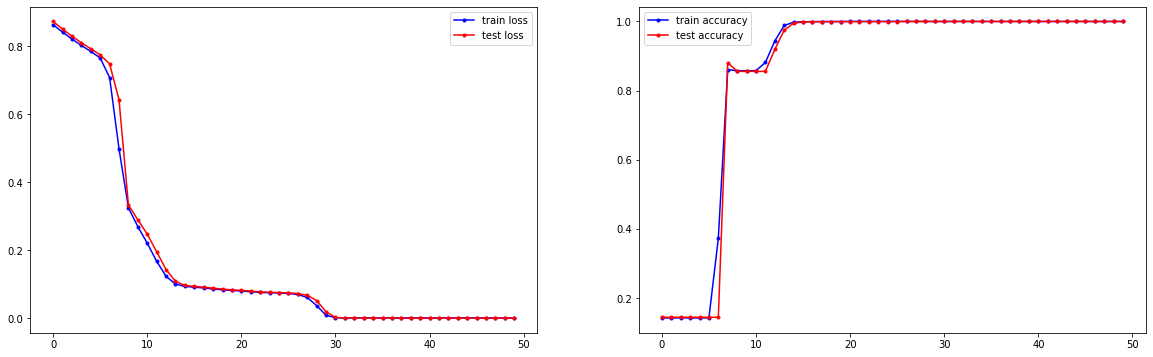

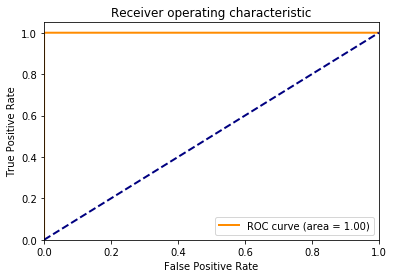

In [15]:
load_model = False
if load_model:
  model = LogisticRegressionModel(input_dim, *params)
  model.load_state_dict(torch.load("/content/gdrive/My Drive/PITE/model{}_{}_{}_{}".format(*params)))
  stat_dict = torch.load("/content/gdrive/My Drive/PITE/state{}_{}_{}_{}".format(*params))
else:
  model = LogisticRegressionModel(input_dim, *params)
  print(model)
  stat_dict = {
      "train_loss" : [],
      "test_loss" : [],
      "train_acc" : [],
      "test_acc" : []
  }
print("n_hiden: {}, first_hiden: {}, center_hiden: {} last_hiden: {}".format(*params))
loss_fn = torch.nn.BCELoss().to(device)
optimator = torch.optim.Adam(model.parameters(), lr_rate)
model, stat = train(model, stat_dict, training_generator, epochs, params, optimator, loss_fn)
if model != 0:
  plot_training_classification(stat)
  auc_val = plot_roc(X_test, y_test, model)